In [1]:
import numpy as np
import pygmt as pygmt
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/yohai/workspace/okada_source/')
sys.path.append('/Users/yohai/workspace/okada_source/test/')
from test_utils import *
from okada.okada import *
sys.path.append('../')
from faultSlip.inversion import Inversion

In [176]:
strike, dip, direction = 180,45, 'll'

In [177]:
region=[0,100,0,100]

In [178]:
X, Y = np.meshgrid(np.arange(0, 101, dtype=np.float), np.arange(0, 101, dtype=np.float))
Z = np.ones_like(X) * 0.1

In [179]:
tdf= pd.DataFrame(dict(x=X.flatten() * 1e3, y=Y.flatten() * 1e3, id=0,E=0,Se=0,N=0,Sn=0,U=0,Su=0, lon=X.flatten(), lat=Y.flatten()))
tdf.to_csv('ttt.csv')

In [180]:
stress = np.zeros((X.shape[0], X.shape[1], 3, 3))
disp = np.zeros((X.shape[0], X.shape[1], 3))

## source dislocation

In [187]:
x = 50.01
y = 50.01
z = 0.2
d_strike = np.radians(strike)
d_dip = np.radians(dip)
L = 10.0
W = 10.0
slip_strike = 0.0
slip_dip = 1.0
s_open = 0.0

### plain cords

In [188]:
ccw_to_x_stk = np.pi / 2 - d_strike
ccw_to_x_dip = - d_strike + np.pi
deast = np.cos(ccw_to_x_stk) * L * 0.5
dnorth = np.sin(ccw_to_x_stk) * L * 0.5
"""
p1 ------------ p2
   |           |
   |           |
   |           |
p4 ------------ p3

"""
p1 = np.array([x - deast, y - dnorth, z])
p2 = np.array([x + deast, y + dnorth, z])

l = W * np.cos(d_dip)
x_b = x -  np.cos(ccw_to_x_dip) * l
y_b = y - np.sin(ccw_to_x_dip) * l
p3 = np.array([x_b + deast, y_b + dnorth, z + W * np.sin(d_dip)])
p4 = np.array([x_b - deast, y_b - dnorth, z + W * np.sin(d_dip)])
plain_cords = np.stack((p1, p2, p3, p4))
plain_cords

array([[50.01      , 55.01      ,  0.2       ],
       [50.01      , 45.01      ,  0.2       ],
       [42.93893219, 45.01      ,  7.27106781],
       [42.93893219, 55.01      ,  7.27106781]])

In [189]:
inv_pars = '''{
"global_parameters":
	{
	"poisson_ratio":0.25,
	"shear_modulus":30e9,
	"smooth":0.1,
	"dip_element":1,
	"strike_element":1,
    "open_element":0,
	"compute_mean":false,
	"boundary_constrained":false
	},
"plains":
	{
	"plain1":
		{
		"dip":%f,
		"strike":%f,
		"plain_cord":[%f, %f, %f],
		"plain_length":%f,
		"width":[%f],
		"num_sub_stk":[1],
		"smooth_up":[],
		"strike_element":%f,
		"dip_element":%f,
		 "total_width":10
		}
	},
"gps":
	{
	"gps_set_1":
		{
		"data":"./ttt.csv"
		}
	}
}

''' %(np.degrees(d_dip), np.degrees(d_strike), plain_cords[0, 0], plain_cords[0, 1], plain_cords[0, 2], L, W, slip_strike, slip_dip)

In [190]:
with open('__temp.json', 'w') as f:
    f.write(inv_pars)
inv = Inversion('__temp.json')

In [191]:
inv.plains[0].sources[0].get_cords().T

array([[42.93893219, 45.01      , -7.27106781],
       [42.93893219, 55.01      , -7.27106781],
       [50.01      , 55.01      , -0.2       ],
       [50.01      , 45.01      , -0.2       ]])

In [192]:
plain_cords

array([[50.01      , 55.01      ,  0.2       ],
       [50.01      , 45.01      ,  0.2       ],
       [42.93893219, 45.01      ,  7.27106781],
       [42.93893219, 55.01      ,  7.27106781]])

## reciver dislocation

In [193]:
r_strike = np.radians(strike)
r_dip = np.radians(dip)
r_rake = np.radians(-90)

In [194]:
yang_mod = 8*1e6
poisson = 0.25
lame_lambda = (yang_mod * poisson) / ((1 + poisson) * ( 1 - 2 * poisson))
shear_mod = yang_mod / (2 * (1 + poisson))
lame_lambda, shear_mod

(3200000.0, 3200000.0)

In [195]:
d_strike, d_dip

(3.141592653589793, 0.7853981633974483)

In [196]:
for ix in range(X.shape[0]):
    for jx in range(X.shape[1]):
        u, s = psokada_t(x, y, z, d_strike, d_dip, L, W, slip_strike, slip_dip, s_open, X[ix, jx], Y[ix, jx], Z[ix, jx], lame_lambda, shear_mod)
        stress[ix, jx]  = s
        disp[ix, jx] = u

In [197]:
n_hat = normal(r_strike, r_dip)
shear_hat = shear(r_strike, r_dip, r_rake)

In [198]:
t = np.squeeze(stress.dot(n_hat))
tn = np.squeeze(t.dot(n_hat))
ts = np.squeeze(t.dot(shear_hat))
coulomb = ts + 0.4 * tn

In [199]:
ux = get_array(disp[:, :, 0], X[0, :], Y[:, 0])
uy = get_array(disp[:, :, 1], X[0, :], Y[:, 0])
uz = get_array(disp[:, :, 2], X[0, :], Y[:, 0])
normal_da = get_array(tn, X[0, :], Y[:, 0])
shear_da = get_array(ts, X[0, :], Y[:, 0])
coulomb_da = get_array(coulomb, X[0, :], Y[:, 0])

In [200]:
region=[0,100,0,100]

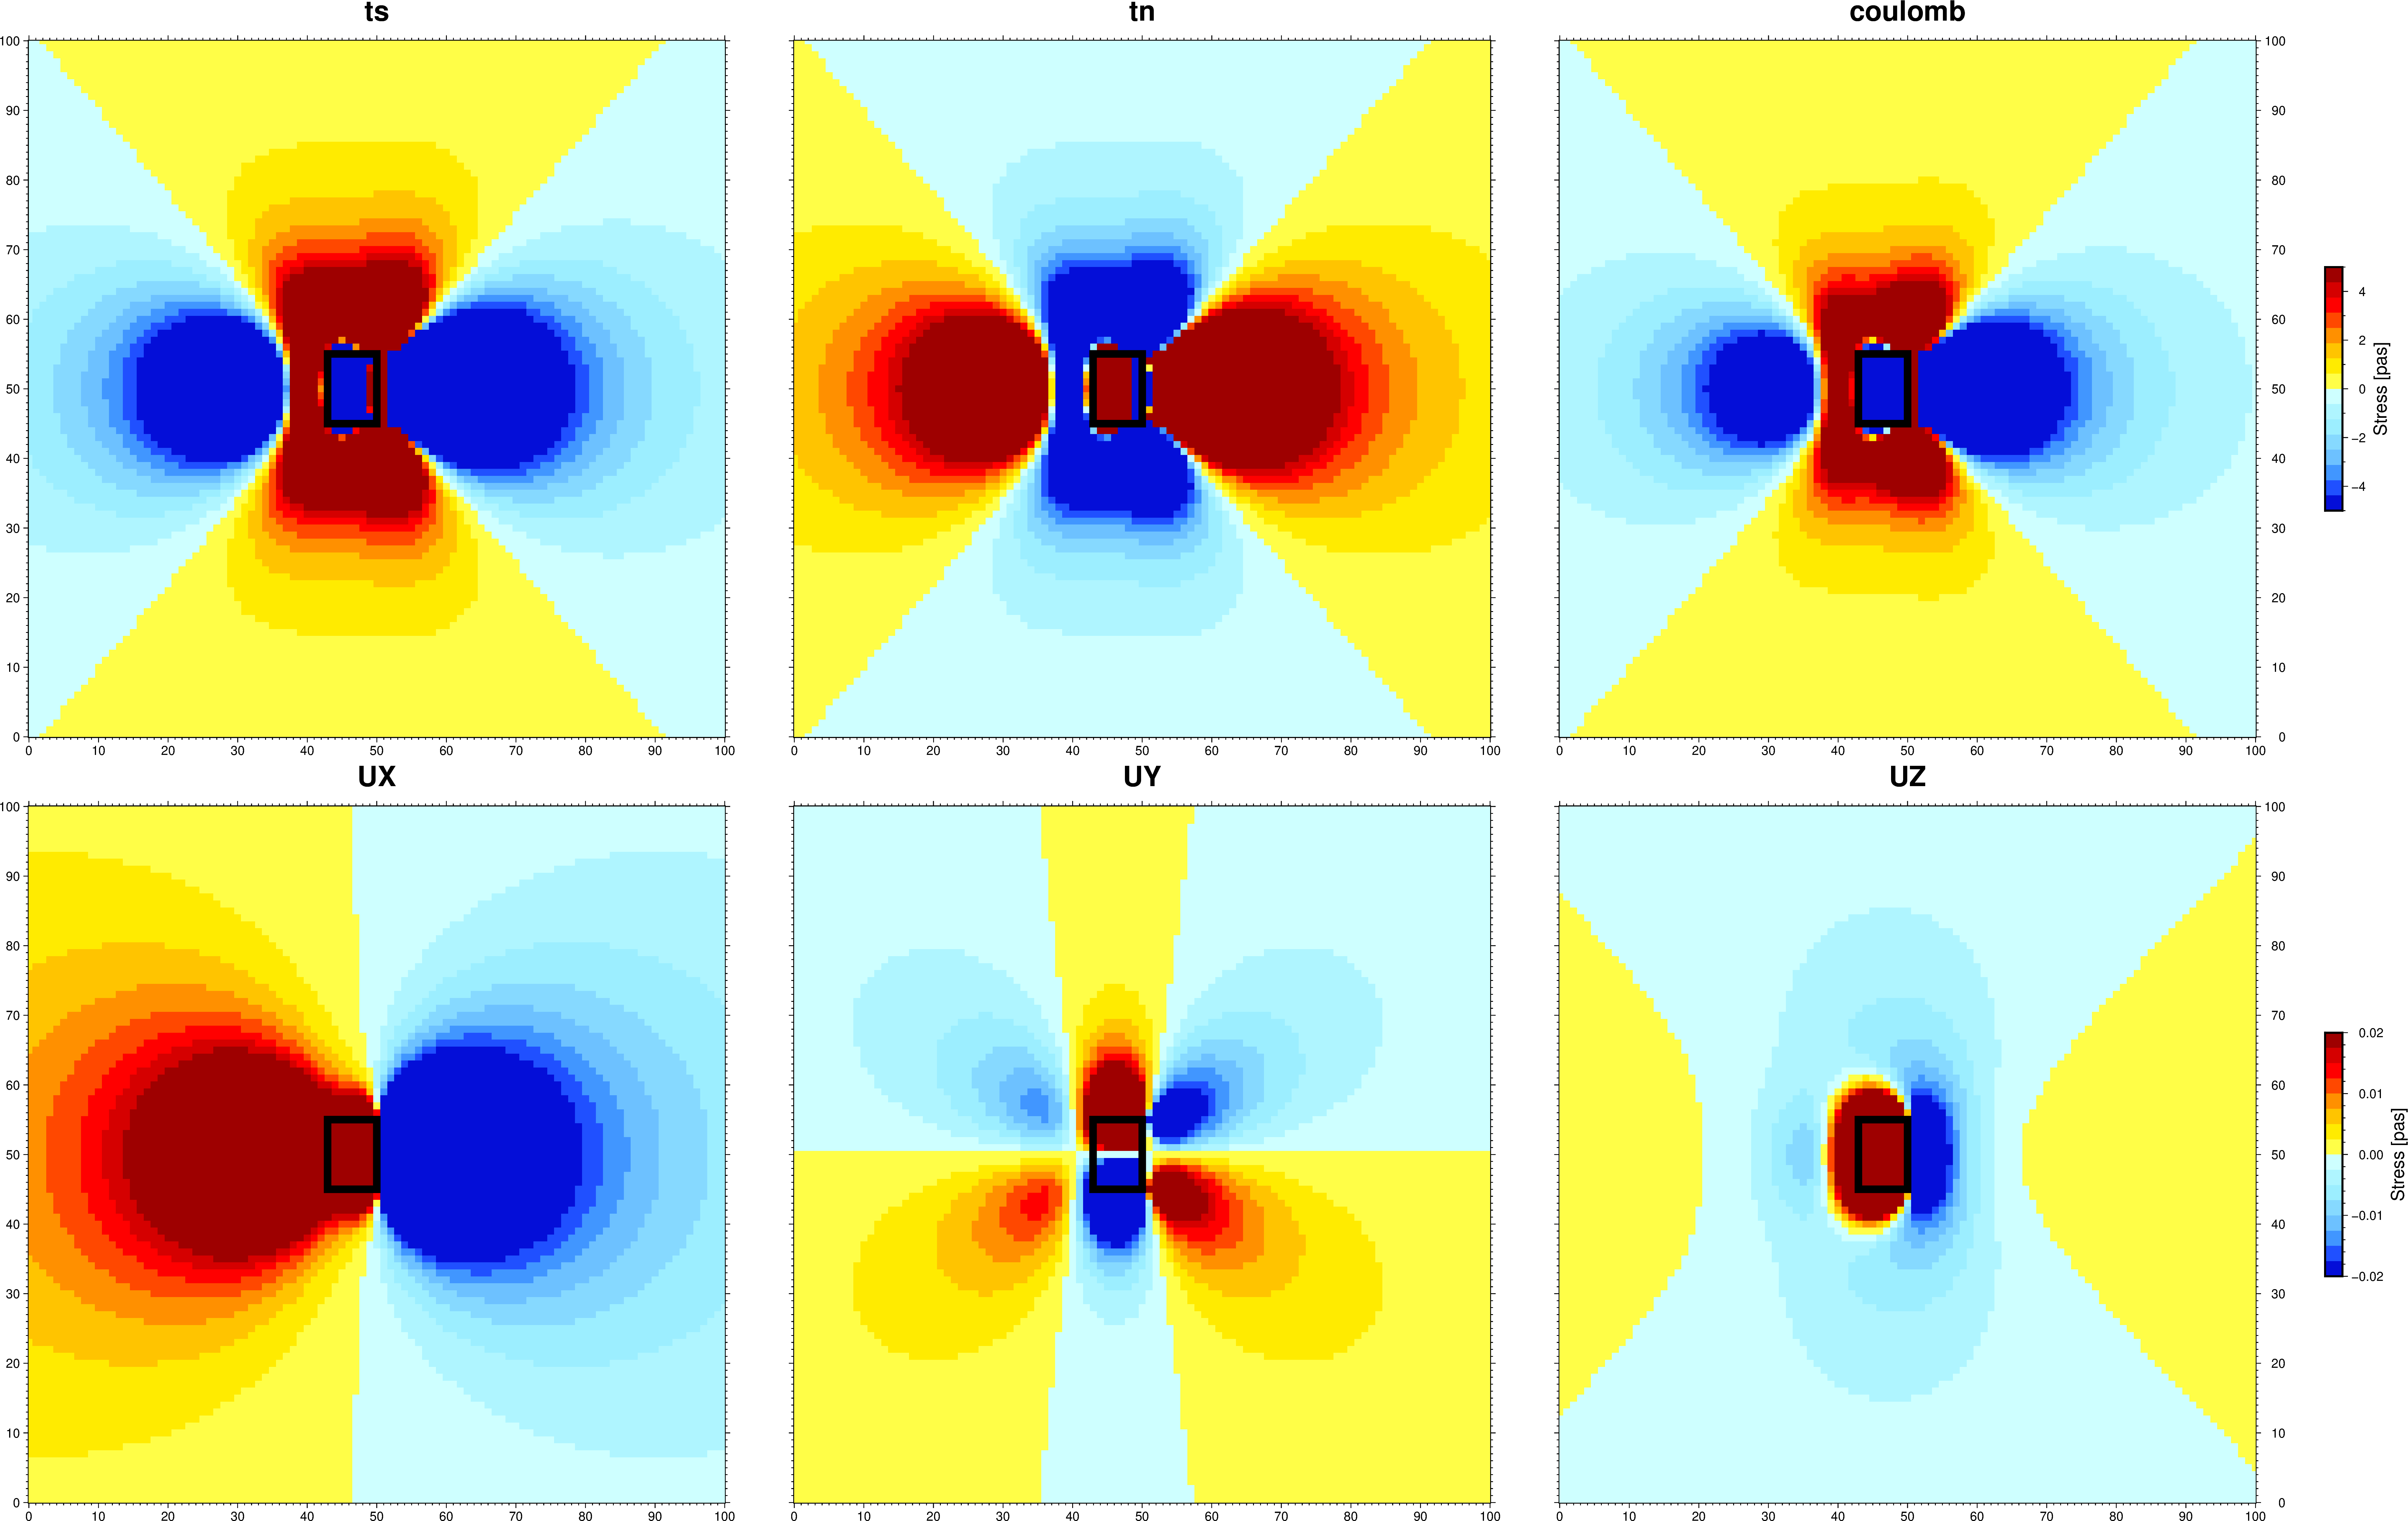

In [201]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

fig.basemap(
    frame=['WSne+t"UX"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
mmax = 0.02#max(float(ux.max().data), float(uy.max().data), float(uz.max().data)) * 0.1
mmin = -0.02#min(float(ux.min().data), float(uy.min().data), float(uz.min().data)) * 0.1
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=ux)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"UY"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=uy)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"UZ"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=uz)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')

fig.shift_origin(xshift='-44c', yshift='22c')

fig.basemap(
    frame=['WSne+t"ts"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
mmax = 5#float(shear_da.max().data) * 0.05
mmin = -5#float(shear_da.min().data) * 0.05
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=shear_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"tn"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=normal_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"coulomb"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=coulomb_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')


fig.show(width=1200)

In [202]:
inv.solution = np.array([np.abs(slip_strike), np.abs(slip_dip)])
strike_slip = np.array([0.0])
inv.build_kers()
inv.build_sources_mat()
plain_cords = inv.plains[0].sources[0].get_cords().T
inv_disp = inv.gps[0].save_model(inv.solution)
inv_ux = get_array(inv_disp.E.values.reshape(X.shape), X[0, :], Y[:, 0])
inv_uy = get_array(inv_disp.N.values.reshape(X.shape), X[0, :], Y[:, 0])
inv_uz = get_array(inv_disp.Up.values.reshape(X.shape), X[0, :], Y[:, 0])


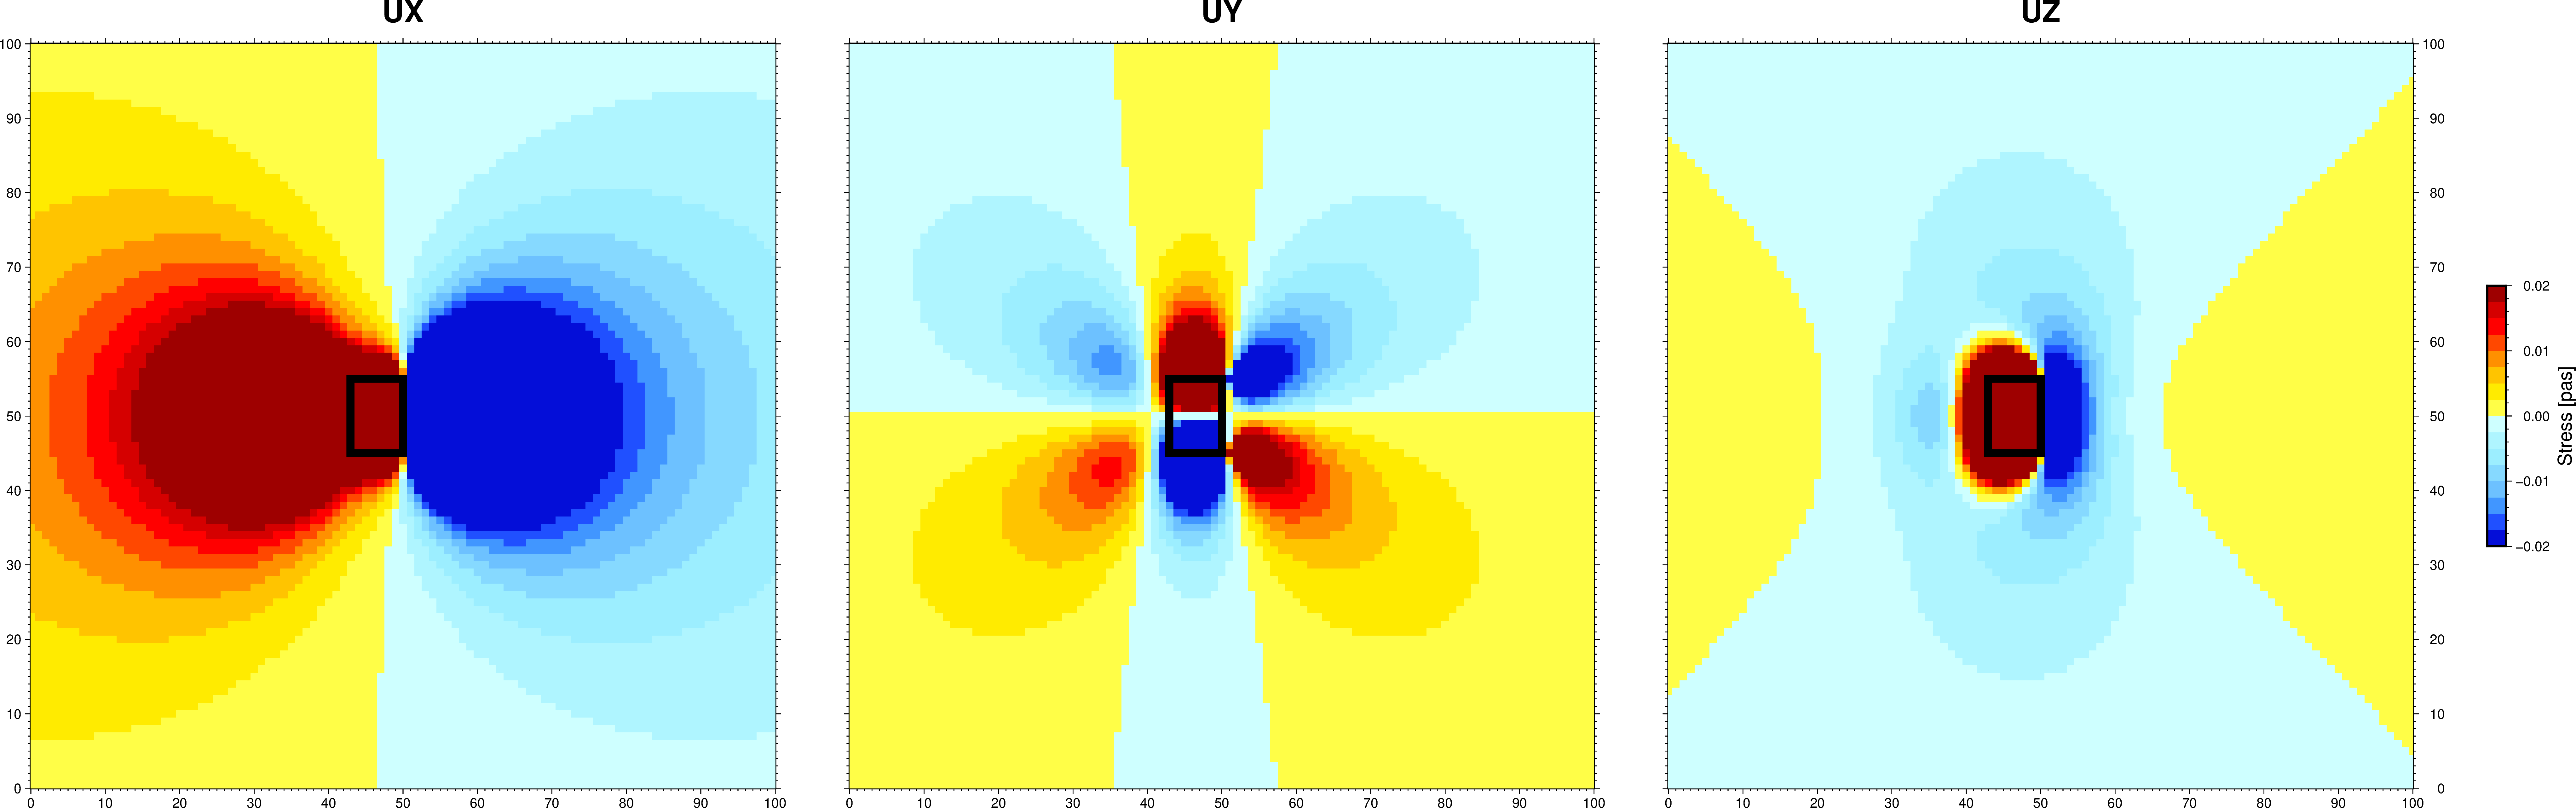

In [203]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

fig.basemap(
    frame=['WSne+t"UX"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
mmax = 0.02#max(float(ux.max().data), float(uy.max().data), float(uz.max().data)) * 0.1
mmin = -0.02#min(float(ux.min().data), float(uy.min().data), float(uz.min().data)) * 0.1
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=inv_ux)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"UY"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_uy)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"UZ"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_uz)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')

fig.show()

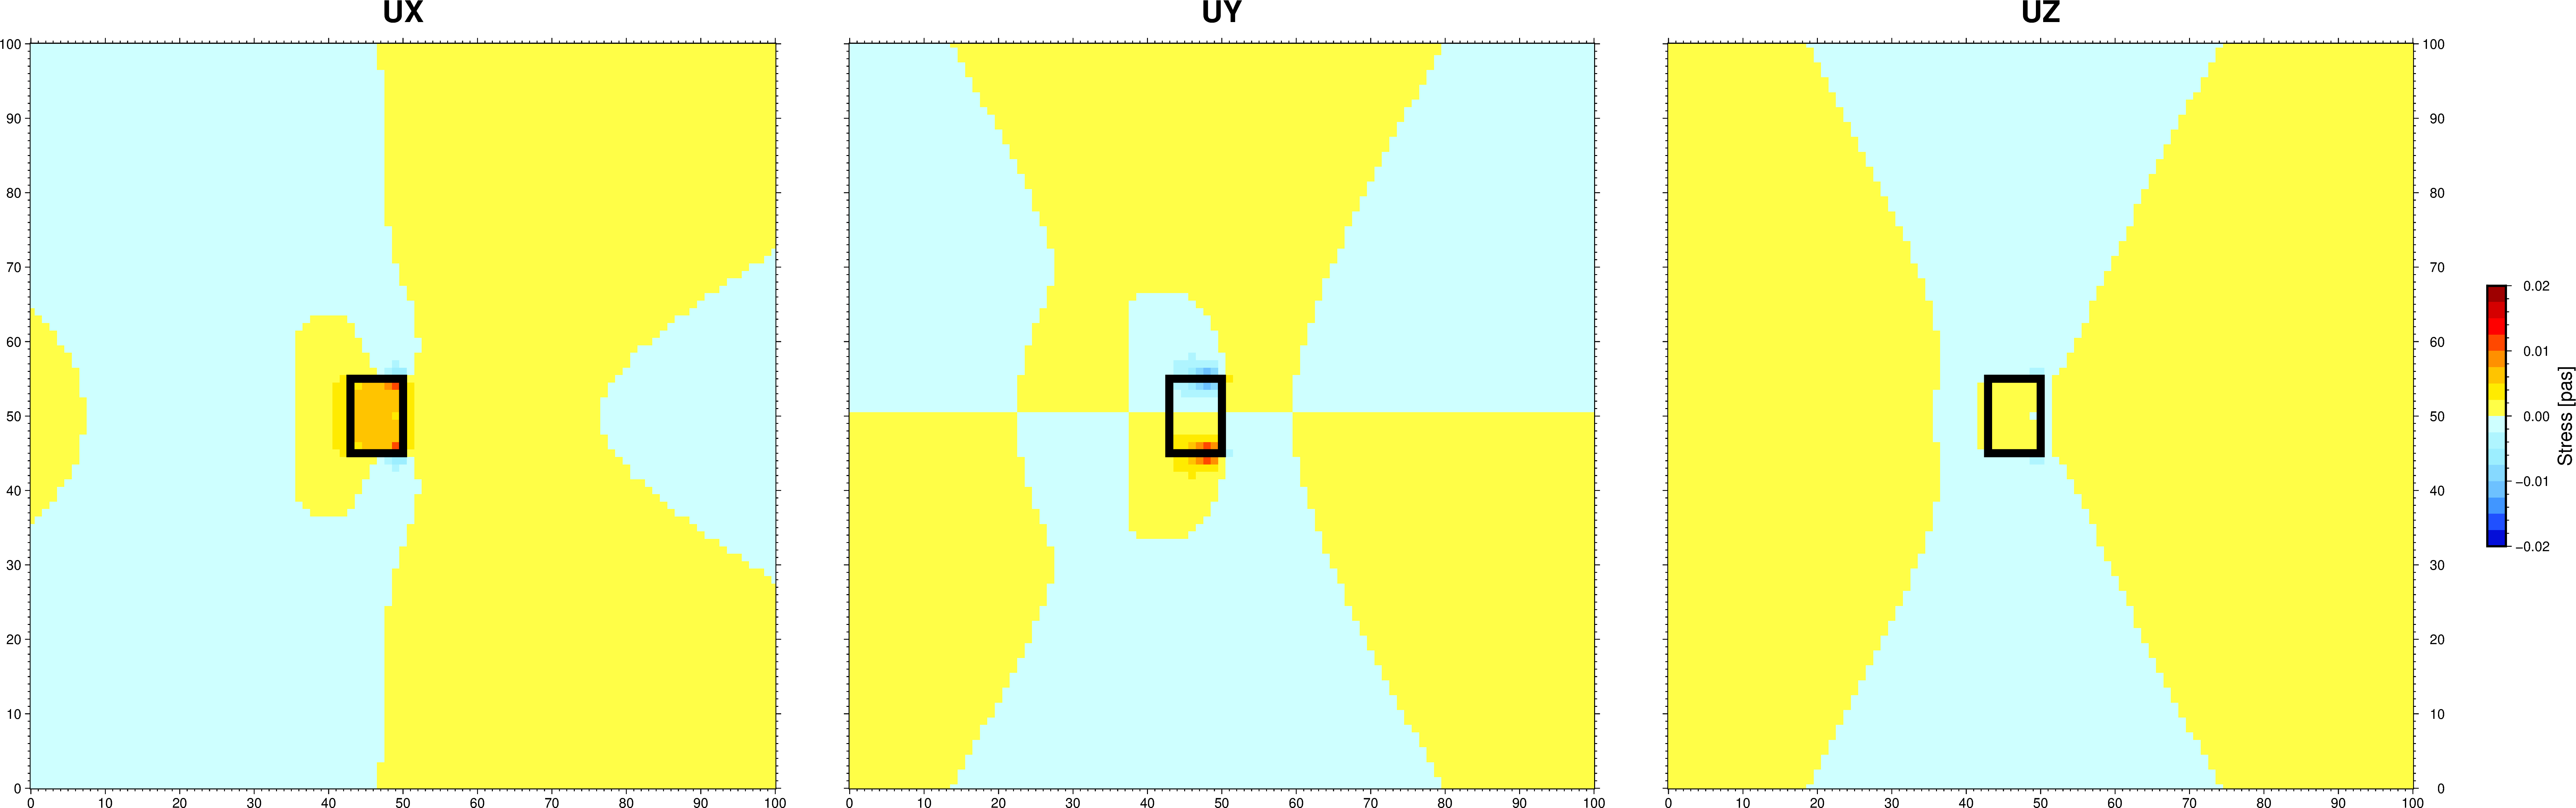

In [204]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

fig.basemap(
    frame=['WSne+t"UX"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
mmax = 0.02#max(float(ux.max().data), float(uy.max().data), float(uz.max().data)) * 0.1
mmin = -0.02#min(float(ux.min().data), float(uy.min().data), float(uz.min().data)) * 0.1
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=inv_ux - ux)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"UY"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_uy - uy)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"UZ"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_uz - uz)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')

fig.show()

In [205]:
coulomb, tn, ts = inv.calc_coulomb_2d(0.4, X, Y, Z, np.degrees(r_strike), np.degrees(r_dip),
                                      np.degrees(r_rake), lambda_l=lame_lambda, shear_m=shear_mod)
inv_tn = get_array(tn, X[0, :], Y[:, 0])
inv_ts = get_array(ts, X[0, :], Y[:, 0])
inv_coulomb = get_array(coulomb, X[0, :], Y[:, 0])

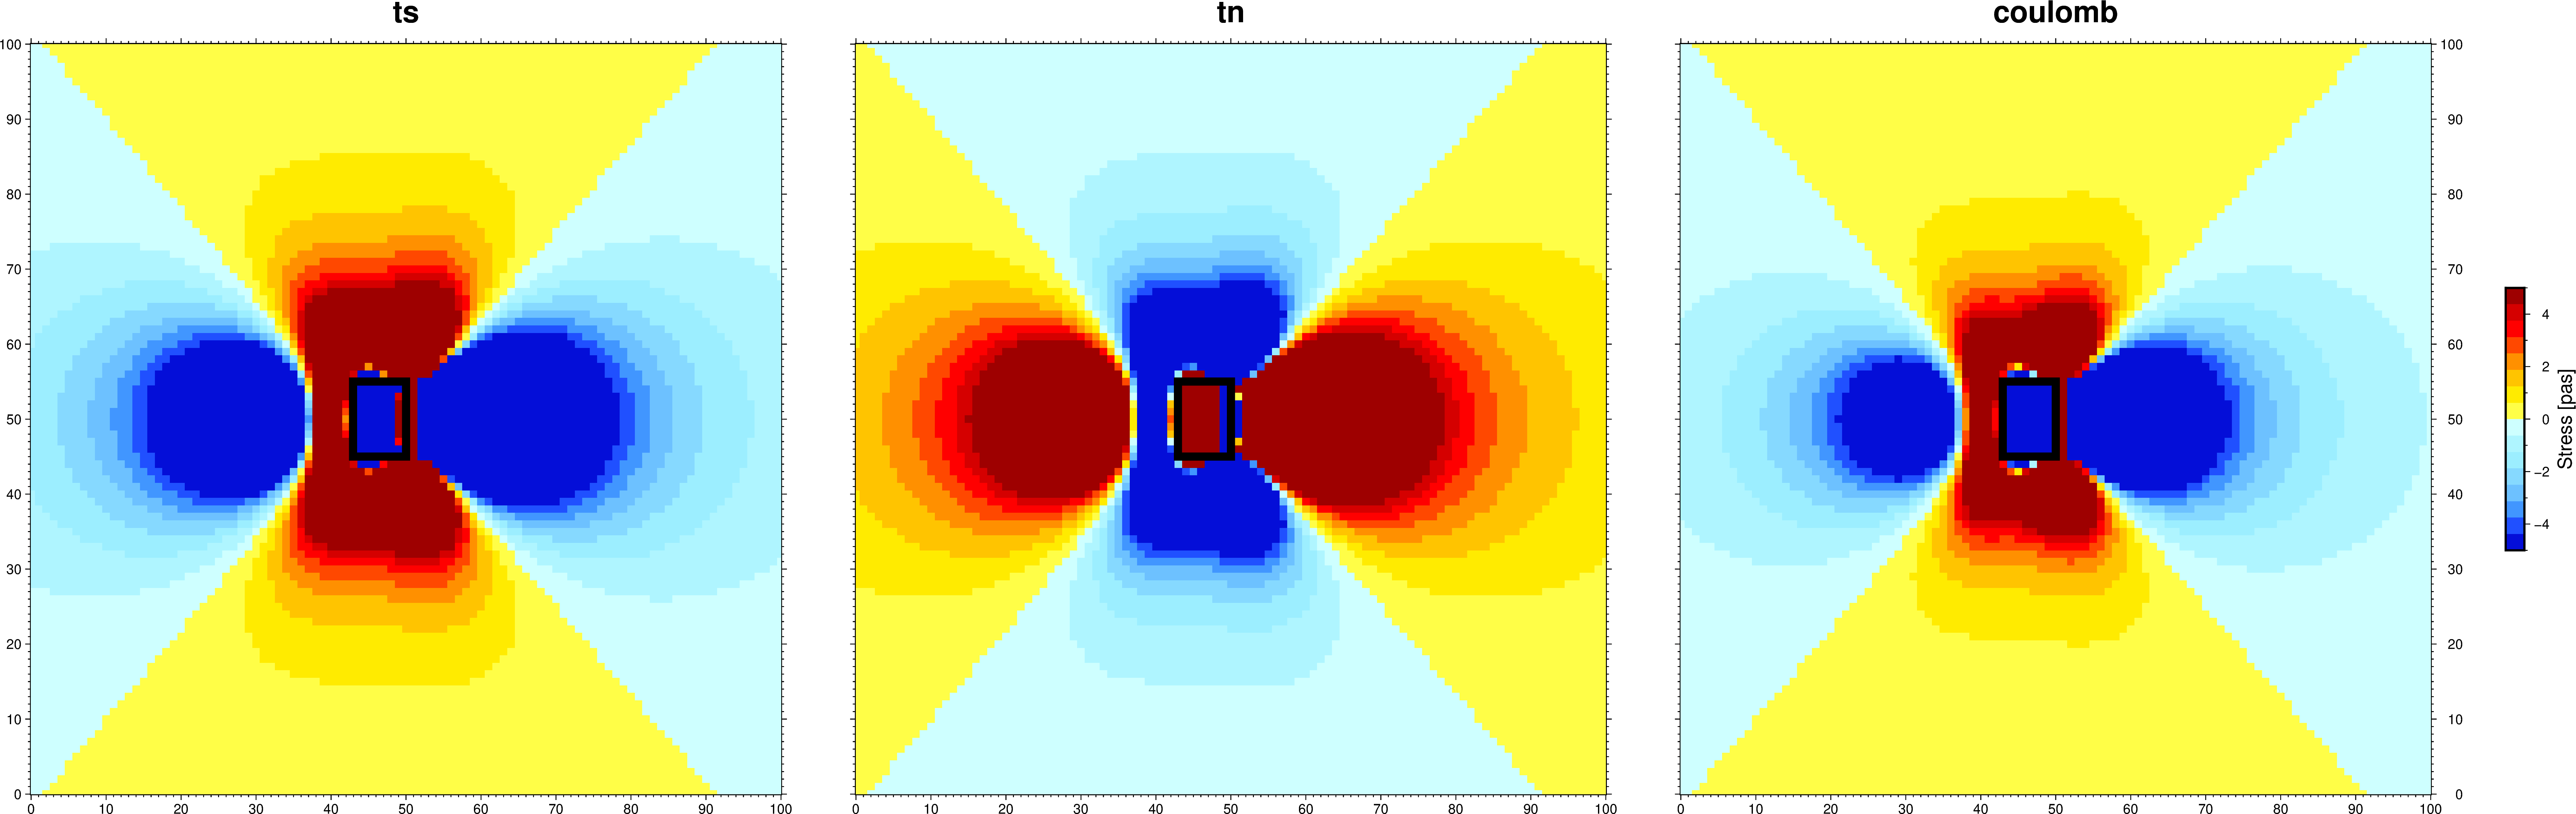

In [206]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

fig.basemap(
    frame=['WSne+t"ts"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
mmax = 5#max(float(ux.max().data), float(uy.max().data), float(uz.max().data)) * 0.1
mmin = -5#min(float(ux.min().data), float(uy.min().data), float(uz.min().data)) * 0.1
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=inv_ts)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"tn"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_tn)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"coulomb"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_coulomb)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')

fig.show()

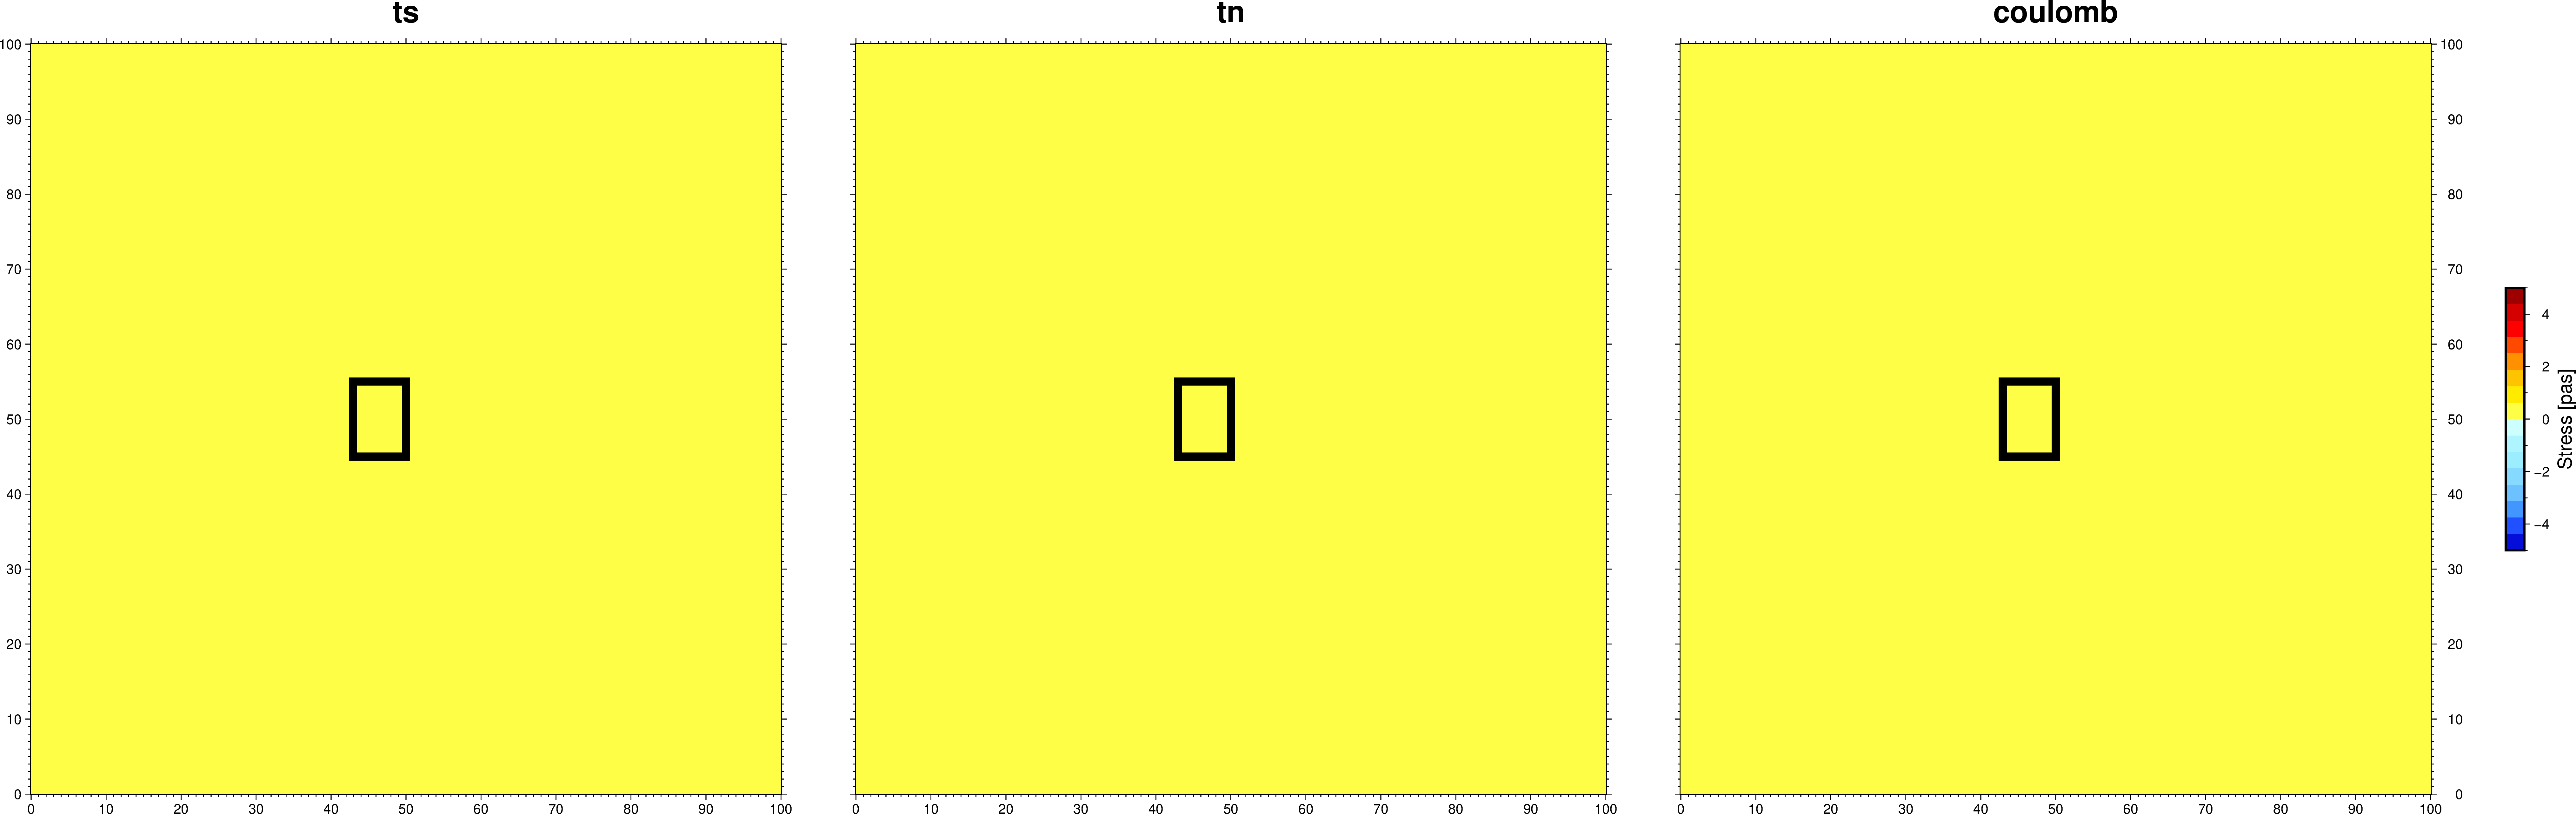

In [207]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

fig.basemap(
    frame=['WSne+t"ts"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
mmax = 5#max(float(ux.max().data), float(uy.max().data), float(uz.max().data)) * 0.1
mmin = -5#min(float(ux.min().data), float(uy.min().data), float(uz.min().data)) * 0.1
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=inv_ts - shear_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"tn"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_tn - normal_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"coulomb"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_coulomb - coulomb_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')

fig.show()

In [214]:
X, Z = np.meshgrid(np.linspace(0, 100, 100), np.linspace(0, -20, 100))
Y = np.ones_like(X) * 50.0

In [215]:
coulomb, tn, ts = inv.calc_coulomb_2d(0.4, X, Y, Z, np.degrees(r_strike), np.degrees(r_dip),
                                      np.degrees(r_rake), lambda_l=lame_lambda, shear_m=shear_mod)
tn_da = get_array(tn, X[0, :], Z[:, 0])
ts_da = get_array(ts, X[0, :], Z[:, 0])
coulomb_da = get_array(coulomb, X[0, :], Z[:, 0])

In [30]:
stress = np.zeros((X.shape[0], X.shape[1], 3, 3))
disp = np.zeros((X.shape[0], X.shape[1], 3))

In [31]:
for ix in range(X.shape[0]):
    for jx in range(X.shape[1]):
        u, s = psokada_t(x, y, z, d_strike, d_dip, L, W, slip_strike, slip_dip, s_open, X[ix, jx], Y[ix, jx], Z[ix, jx], lame_lambda, shear_mod)
        stress[ix, jx]  = s
        disp[ix, jx] = u

In [33]:
t = np.squeeze(stress.dot(n_hat))
tn = np.squeeze(t.dot(n_hat))
ts = np.squeeze(t.dot(shear_hat))
coulomb = ts + 0.4 * tn

In [34]:
ux = xr.DataArray(
    data=disp[:, :, 0],
    dims=['y', 'x'],
    coords=dict(
        x=(['x'], X[0, :]),
        y=(['y'], Z[:, 0])
    )
)
uy = xr.DataArray(
    data=disp[:, :, 1],
    dims=['y', 'x'],
    coords=dict(
        x=(['x'], X[0, :]),
        y=(['y'], Z[:, 0])
    )
)
uz = xr.DataArray(
    data=disp[:, :, 2],
    dims=['y', 'x'],
    coords=dict(
        x=(['x'], X[0, :]),
        y=(['y'], Z[:, 0])
    )
)

In [35]:
normal_da = xr.DataArray(
    data=tn,
    dims=['y', 'x'],
    coords=dict(
        x=(['x'], X[0, :]),
        y=(['y'], Z[:, 0])
    )
)
shear_da = xr.DataArray(
    data=ts,
    dims=['y', 'x'],
    coords=dict(
        x=(['x'], X[0, :]),
        y=(['y'], Z[:, 0])
    )
)
coulomb_da = xr.DataArray(
    data=coulomb,
    dims=['y', 'x'],
    coords=dict(
        x=(['x'], X[0, :]),
        y=(['y'], Z[:, 0])
    )
)

In [209]:
region=[0,100,-20,0]

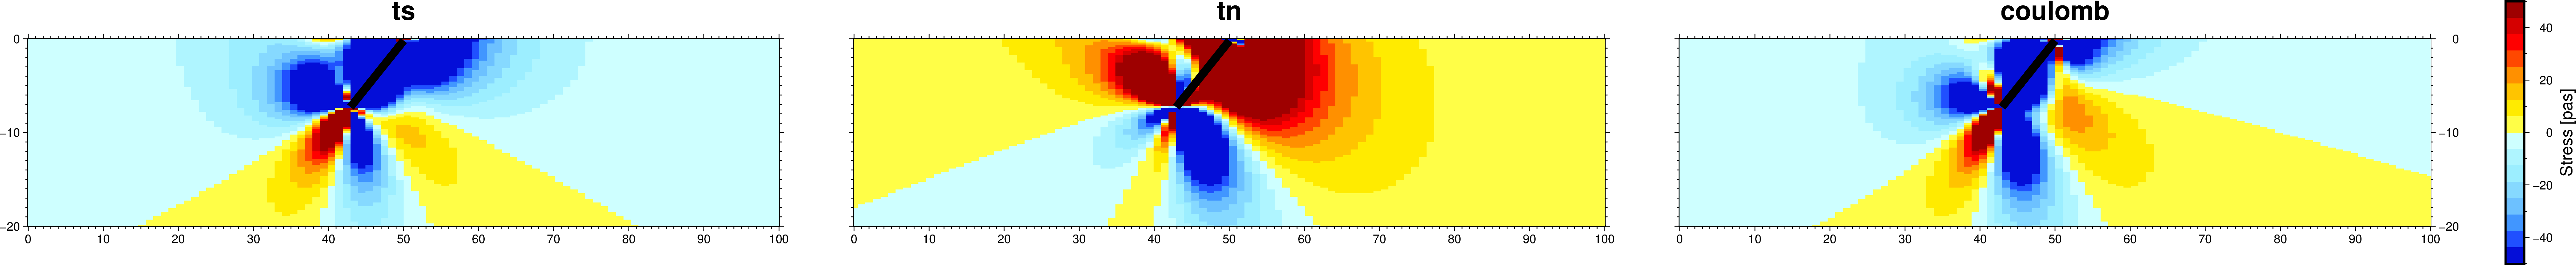

In [217]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

# fig.basemap(
#     frame=['WSne+t"UX"', 'xa10f1g10', 'ya10f1g10'],
#     projection=f"X20/5",
#     region=region
# )
# mmax = max(float(ux.max().data), float(uy.max().data), float(uz.max().data) )* 0.1
# mmin = min(float(ux.min().data), float(uy.min().data), float(uz.min().data) )* 0.1
# pygmt.makecpt(cmap="jet", series=[mmin,mmax, (mmax - mmin) / 1000], background=True)

# fig.grdimage(grid=ux)
# fig.plot(
#     x= plain_cords[:, 0],
#     y = plain_cords[:, 1],
#     pen='6,black',
#     close=True
# )
# fig.shift_origin(xshift='22')
# fig.basemap(
#     frame=['wSne+t"UY"', 'xa10f1g10', 'ya10f1g10'],
#     projection=f"X20/5",
#     region=region
# )

# fig.grdimage(grid=uy)
# fig.plot(
#     x= plain_cords[:, 0],
#     y = plain_cords[:, 1],
#     pen='6,black',
#     close=True
# )

# fig.shift_origin(xshift='22')
# fig.basemap(
#     frame=['wSnE+t"UZ"', 'xa10f1g10', 'ya10f1g10'],
#     projection=f"X20/5",
#     region=region
# )

# fig.grdimage(grid=uz)
# fig.plot(
#     x= plain_cords[:, 0],
#     y = plain_cords[:, 1],
#     pen='6,black',
#     close=True
# )
# fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')

# fig.shift_origin(xshift='-44c', yshift='7c')

fig.basemap(
    frame=['WSne+t"ts"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20/5",
    region=region
)
mmax = 50#float(shear_da.max().data) * 0.05
mmin = -50#float(shear_da.min().data) * 0.05
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=ts_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 2],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"tn"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20/5",
    region=region
)

fig.grdimage(grid=tn_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 2],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"coulomb"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20/5",
    region=region
)

fig.grdimage(grid=coulomb_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 2],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')

fig.show(width=1200)